In [1]:
#Ячейка 1: Импорты
import pandas as pd
import numpy as np
import re
import nltk
import pymorphy2
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from collections import Counter
import warnings

#Настройки для красоты графиков
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
warnings.filterwarnings('ignore')

#Загрузка ресурсов NLTK
try:
    nltk.download('stopwords', quiet=True)
    nltk.download('punkt', quiet=True)
except Exception as e:
    print(f"Ошибка загрузки NLTK: {e}")

print("Библиотеки успешно загружены.")

Библиотеки успешно загружены.


In [2]:
#Ячейка 2: Инициализация инструментов NLP
morph = pymorphy2.MorphAnalyzer()
nltk_stop_words = set(stopwords.words('russian'))

custom_stop_words = {
    'привет', 'меня', 'звать', 'здравствуйте', 'приветик', 'здарова', 'хай',
    'это', 'вот', 'ну', 'да', 'нет', 'так', 'еще', 'уже', 'просто', 'очень',
    'свой', 'моя', 'мой', 'мое', 'работаю', 'работать', 'своя', 'свои', 'своей',
    'свою', 'своих', 'который', 'которая', 'которые', 'которым', 'которыми',
    'любить','нравится','хотеть','уметь','слушать','искать','заниматься',
    'смотреть', 'обожать', 'девушка','парень','человек', 'фильм','музыка',
    'здорово', 'фанат','работа','жизнь', 'реалистичный', 'фанат',
    'мужчина','увлекаться','любимый','изучать','хобби', 'женщина',
    'мечтать','весь', 'создавать', 'коллекционировать','специалист','время',
    'помогать','сериал', 'создание','классический','система', 'свободный','умный',
    'звук','городской', 'ценить', 'искусство', 'история', 'исторический', 'оценить',
    'разрабатывать','старинный','ребёнок', 'редкий', 'разный', 'музей',
    'мастер','древний','традиционный', 'возвращать','красота','встреча',
    'коллекциониий','коллекционирование', 'изучение', 'год', 'андрей'
}
stop_words = nltk_stop_words.union(custom_stop_words)

def preprocess_text(text):
    """Очищает и лемматизирует текст"""
    if not isinstance(text, str) or not text.strip():
        return ""
    
    text = text.lower()
    text = re.sub(r'[^а-яё\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    tokens = word_tokenize(text, language='russian')
    processed_tokens = []
    
    for token in tokens:
        if token in stop_words or len(token) < 2:
            continue
        try:
            parsed = morph.parse(token)[0]
            lemma = parsed.normal_form
            if lemma not in stop_words and len(lemma) > 2:
                processed_tokens.append(lemma)
        except:
            if token not in stop_words and len(token) > 2:
                processed_tokens.append(token)
    
    return ' '.join(processed_tokens)

In [3]:
#Ячейка 3: Загрузка данных

df = pd.read_excel('base_doc.xlsx')

#Базовая очистка: удаляем пустые строки
df = df.dropna(subset=['Описание'])
df = df[df['Описание'].str.strip() != '']

#Применение предобработки
print("Обработка текстов...")
df['processed_text'] = df['Описание'].apply(preprocess_text)


print(f"\nЗагружено профилей: {len(df)}")
print("\n--- Пример обработки ---")
print(f"До:    {df['Описание'].iloc[0]}")
print(f"После: {df['processed_text'].iloc[0]}")

Обработка текстов...

Загружено профилей: 5056

--- Пример обработки ---
До:    Привет! Меня зовут Алексей, мне 25 лет. Работаю программистом в IT-компании, пишу код на Python. Обожаю смотреть "Игру престолов" и "Во все тяжкие" по вечерам после работы. Увлекаюсь футболом, играю за любительскую команду по выходным. Люблю готовить пасту карбонара и экспериментировать с азиатской кухней. Ищу девушку для серьезных отношений, с которой можно и в кино сходить, и дома Netflix посмотреть.
После: алексей программист компания писать код игра престол тяжкий вечер футбол играть любительский команда выходной готовить паста карбонар экспериментировать азиатский кухня серьёзный отношение кино сходить дом посмотреть


In [4]:
#Ячейка 4: Создание эмбеддингов
model_name = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'
print(f"Загрузка модели {model_name}...")
model = SentenceTransformer(model_name)

print("Генерация эмбеддингов (это может занять время)...")
embeddings = model.encode(
    df['processed_text'].tolist(), 
    show_progress_bar=True, 
    batch_size=32
)

print(f"Размерность эмбеддингов: {embeddings.shape}")

Загрузка модели sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2...
Генерация эмбеддингов (это может занять время)...


Batches:   0%|          | 0/158 [00:00<?, ?it/s]

Размерность эмбеддингов: (5056, 384)


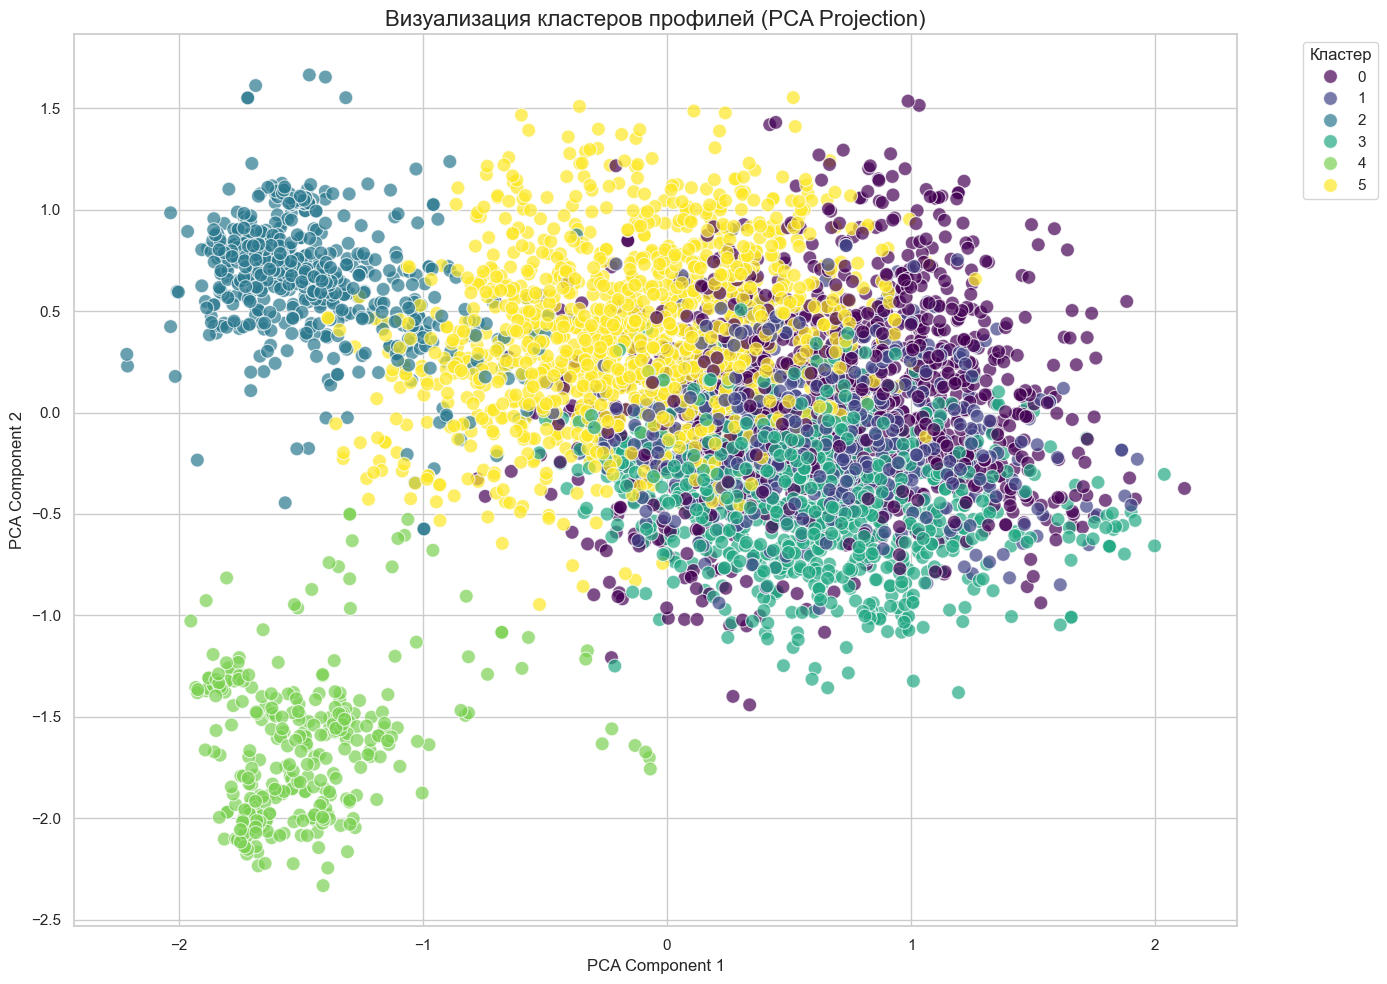

In [5]:
#Ячейка 5: Кластеризация и PCA
n_clusters = 6 # Как в оригинальном коде

#KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(embeddings)
df['cluster'] = clusters

#PCA для визуализации (сжатие 384 измерений BERT в 2 измерения для графика)
pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(embeddings)
df['pca_x'] = vectors_2d[:, 0]
df['pca_y'] = vectors_2d[:, 1]

# --- ВИЗУАЛИЗАЦИЯ ---
plt.figure(figsize=(14, 10))
scatter = sns.scatterplot(
    data=df, 
    x='pca_x', 
    y='pca_y', 
    hue='cluster', 
    palette='viridis', 
    s=100, 
    alpha=0.7
)
plt.title('Визуализация кластеров профилей (PCA Projection)', fontsize=16)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Кластер', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Кластер    | Кол-во     | Топ слова
--------------------------------------------------------------------------------
0          | 1176       | игра, технология, цифровой, электронный, психология
1          | 626        | природа, растение, ботанический, ботаник, деревенский
2          | 675        | культура, историк, народный, греческий, традиция
3          | 913        | морской, военный, карта, подводный, астрономия
4          | 360        | церковный, семья, духовный, веровать, песнопение
5          | 1306       | инструмент, музыкальный, техника, танец, эпоха


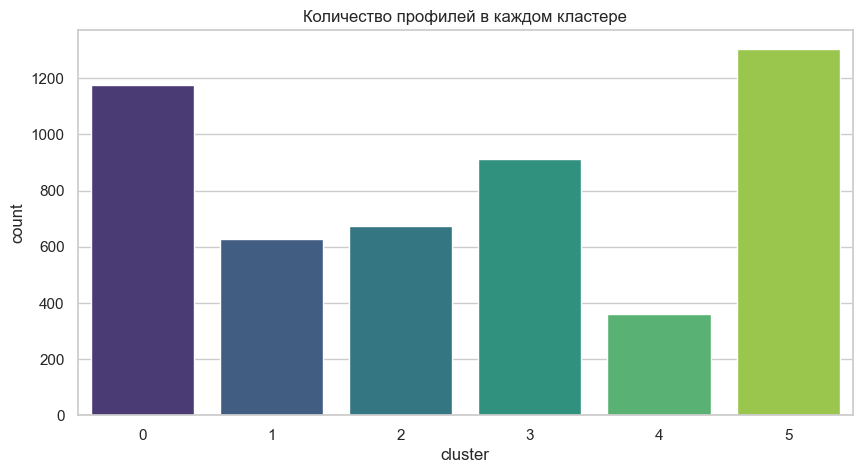

In [6]:
#Ячейка 6: Анализ содержимого кластеров
def get_top_words(texts, n_words=10):
    all_words = []
    for text in texts:
        words = str(text).split()
        all_words.extend([w for w in words if len(w) > 3])
    return Counter(all_words).most_common(n_words)

#Вывод статистики
print(f"{'Кластер':<10} | {'Кол-во':<10} | {'Топ слова'}")
print("-" * 80)

for i in range(n_clusters):
    cluster_data = df[df['cluster'] == i]
    top_words = get_top_words(cluster_data['processed_text'], 5)
    top_words_str = ", ".join([word for word, count in top_words])
    print(f"{i:<10} | {len(cluster_data):<10} | {top_words_str}")

#Визуализация распределения по кластерам
plt.figure(figsize=(10, 5))
sns.countplot(x='cluster', data=df, palette='viridis')
plt.title('Количество профилей в каждом кластере')
plt.show()

In [7]:
#Ячейка 7: Функция поиска похожих профилей
def find_similar_profiles(user_text, top_k=3):
    processed_query = preprocess_text(user_text)
    query_embedding = model.encode([processed_query])
    
    #Расчет схожести
    similarities = cosine_similarity(query_embedding, embeddings)[0]
    
    #Сортировка
    similar_indices = np.argsort(similarities)[::-1][:top_k]
    
    print(f"\n🔎 Запрос: '{user_text}'")
    print(f"🧹 Обработано: '{processed_query}'")
    print("-" * 60)
    
    results = []
    for idx in similar_indices:
        score = similarities[idx]
        desc = df.iloc[idx]['Описание']
        cluster = df.iloc[idx]['cluster']
        print(f"[{score:.4f}] Кластер {cluster}: {desc[:100]}...")
        results.append((idx, score))
    return results

#Тест
test_text = "Я люблю классическую музыку и игру на фортепиано"
_ = find_similar_profiles(test_text)


🔎 Запрос: 'Я люблю классическую музыку и игру на фортепиано'
🧹 Обработано: 'игра фортепиано'
------------------------------------------------------------
[0.8128] Кластер 5:  Приветик! Я Клара, 24 года, работаю в музыкальной школе преподавателем игры на фортепиано. Смотрю "...
[0.8076] Кластер 5: Здорово! Я Каролина, 24 года, работаю в музыкальной школе преподавателем фортепиано. Обожаю "Пианист...
[0.7983] Кластер 5:   Здравствуйте! Меня зовут Антонина, 24 года, работаю в музыкальной школе преподавателем игры на фор...


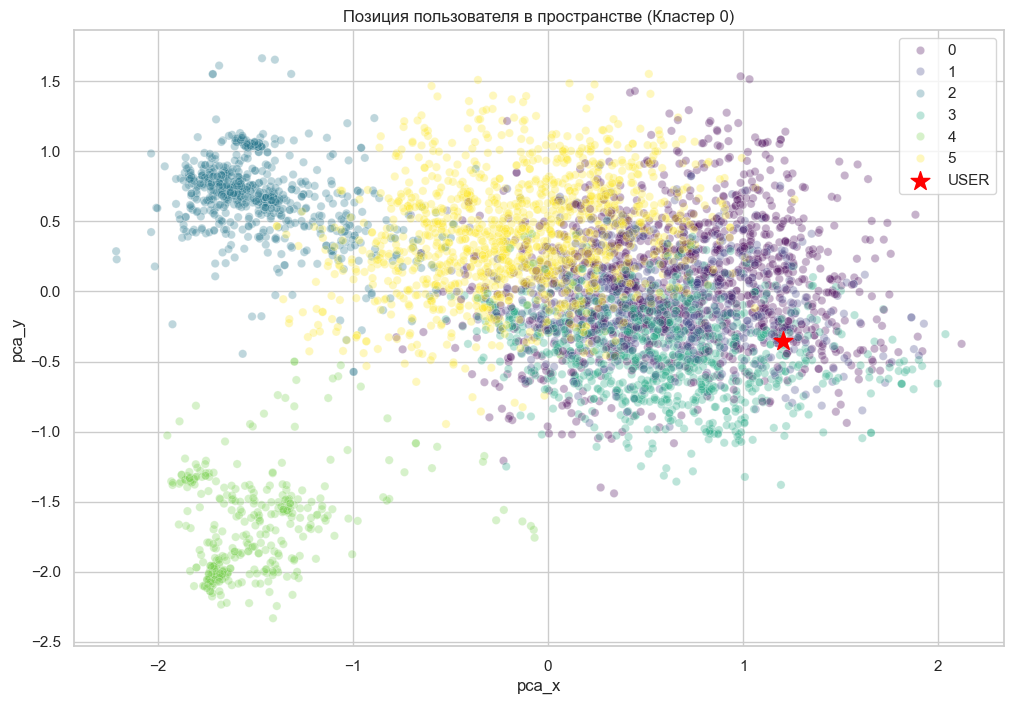

Текст отнесен к кластеру: 0


In [8]:
#Ячейка 8: Предикт кластера с визуализацией
def predict_and_plot(text):
    processed = preprocess_text(text)
    vec = model.encode([processed])
    
    #Предсказание кластера
    pred_cluster = kmeans.predict(vec)[0]
    
    #PCA трансформация для новой точки
    vec_2d = pca.transform(vec)
    
    #Рисуем график
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=df, x='pca_x', y='pca_y', hue='cluster', palette='viridis', alpha=0.3)
    
    #Добавляем точку пользователя
    plt.scatter(vec_2d[0][0], vec_2d[0][1], c='red', s=200, marker='*', label='USER')
    
    plt.title(f'Позиция пользователя в пространстве (Кластер {pred_cluster})')
    plt.legend()
    plt.show()
    
    print(f"Текст отнесен к кластеру: {pred_cluster}")

#Тестирование
predict_and_plot("Обожаю программирование и нейронные сети")

______________________________________________________________________________________________________________________________________________

In [9]:
def analyze_text(text, show_plots=True):
    """
    Анализирует текст, определяет кластер и показывает уверенность модели.
    """
    #Обработка
    processed = preprocess_text(text)
    if not processed:
        print(f"⚠️ Текст '{text}' не содержит ключевых слов.")
        return
        
    #Векторизация
    vec = model.encode([processed])
    
    #Расчет расстояний до центров всех кластеров
    distances = kmeans.transform(vec)[0]
    
    #Выбор лучшего и расчет уверенности
    pred_cluster = np.argmin(distances) #Индекс самого близкого
    min_dist = distances[pred_cluster]  #Дистанция до него
    
    #Формула уверенности: чем меньше дистанция, тем больше число (0..1)
    confidence = 1.0 / (1.0 + min_dist)
    
    #Вывод результатов
    print(f"\n{'='*40}")
    print(f"Текст: {text}")
    print(f"Ключевые слова: {processed}")
    print(f"🎯 Результат: КЛАСТЕР {pred_cluster}")
    print(f"📊 Уверенность: {confidence:.1%} (Дистанция: {min_dist:.3f})")
    print(f"{'='*40}")

    if show_plots:
        #График 1: Положение среди других
        vec_2d = pca.transform(vec)
        
        plt.figure(figsize=(12, 5))
        
        #Левый график: Карта кластеров
        plt.subplot(1, 2, 1)
        sns.scatterplot(data=df, x='pca_x', y='pca_y', hue='cluster', palette='viridis', alpha=0.3, legend=False)
        #Центры
        centers_2d = pca.transform(kmeans.cluster_centers_)
        plt.scatter(centers_2d[:, 0], centers_2d[:, 1], c='black', s=50, marker='x')
        #Точка пользователя
        plt.scatter(vec_2d[0][0], vec_2d[0][1], c='red', s=200, marker='*', edgecolors='black', label='Ваш текст')
        plt.title(f'Ваше место на карте (Кластер {pred_cluster})')
        plt.legend()
        
        #Правый график: Столбики расстояний
        plt.subplot(1, 2, 2)
        #Инвертируем дистанцию для наглядности (выше столбик = больше похожесть)
        similarity_scores = 1 / (1 + distances)
        bars = plt.bar(range(n_clusters), similarity_scores, color='lightgray')
        bars[pred_cluster].set_color('red') 
        
        plt.title('Насколько текст похож на каждую тему?')
        plt.xlabel('Номер кластера')
        plt.ylabel('Сходство')
        plt.xticks(range(n_clusters))
        
        plt.tight_layout()
        plt.show()

print("✅ Функция анализа готова.")

✅ Функция анализа готова.



Текст: Я обожаю программировать нейросети на Python
Ключевые слова: программировать нейросеть
🎯 Результат: КЛАСТЕР 0
📊 Уверенность: 28.2% (Дистанция: 2.548)


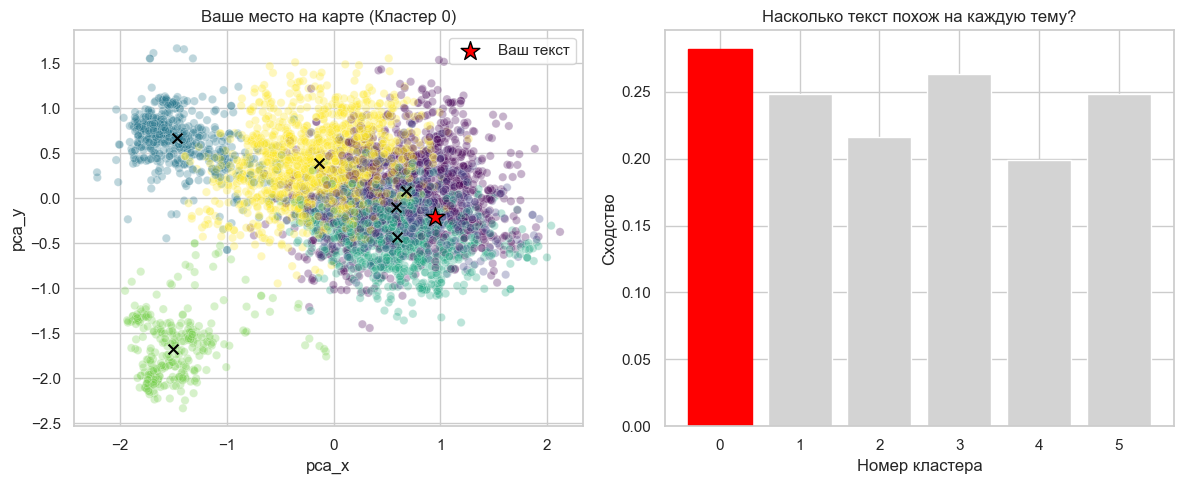


Текст: В свободное время играю на гитаре и пишу песни
Ключевые слова: играть гитара писать песня
🎯 Результат: КЛАСТЕР 5
📊 Уверенность: 19.8% (Дистанция: 4.048)


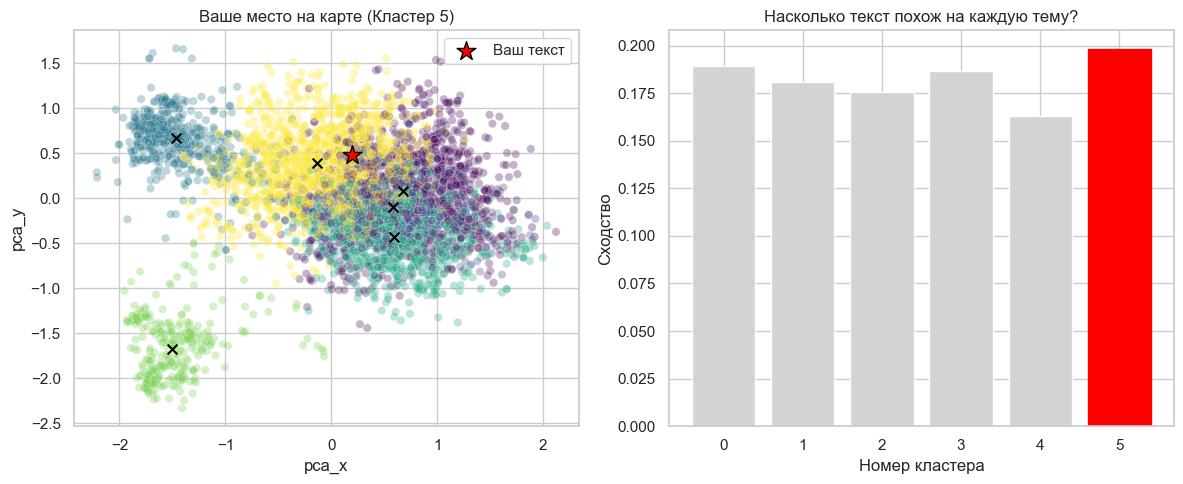


Текст: Люблю готовить пироги для всей семьи
Ключевые слова: готовить пирог семья
🎯 Результат: КЛАСТЕР 5
📊 Уверенность: 16.8% (Дистанция: 4.950)


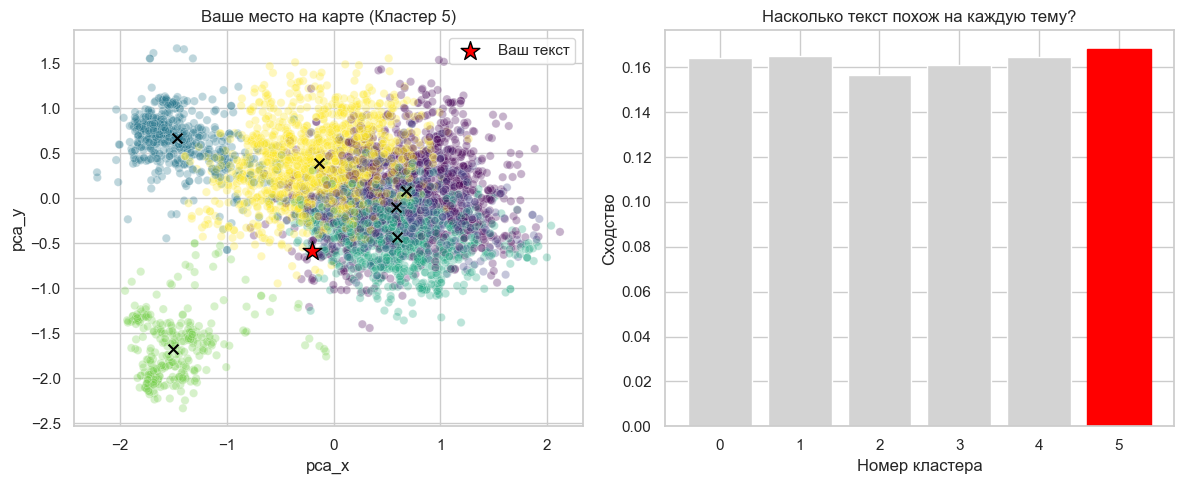


Текст: Не знаю чем заняться, просто лежу
Ключевые слова: знать заняться лежать
🎯 Результат: КЛАСТЕР 0
📊 Уверенность: 27.1% (Дистанция: 2.689)


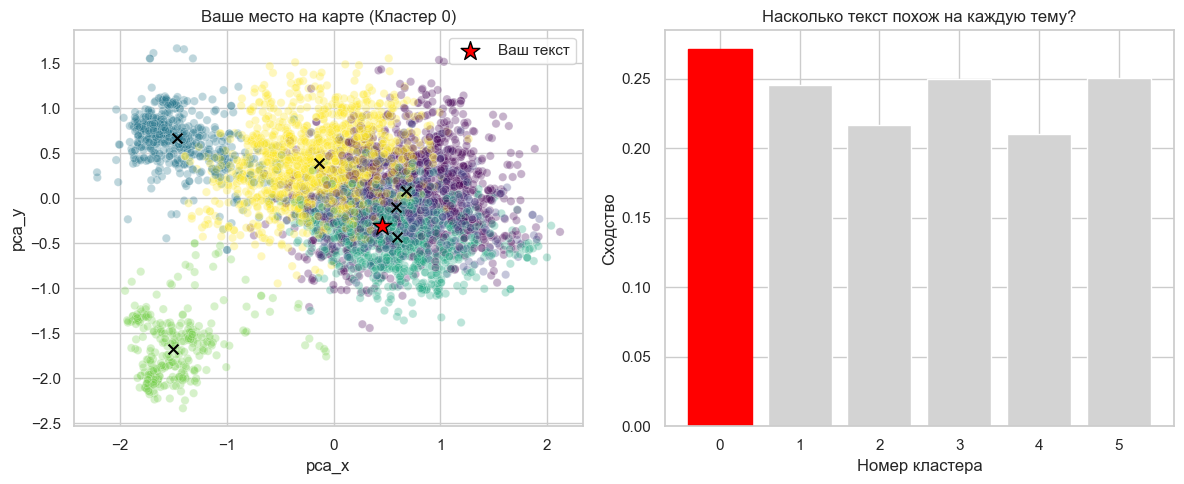


Текст: История древнего Рима и археологические раскопки
Ключевые слова: рим археологический раскопка
🎯 Результат: КЛАСТЕР 2
📊 Уверенность: 17.1% (Дистанция: 4.845)


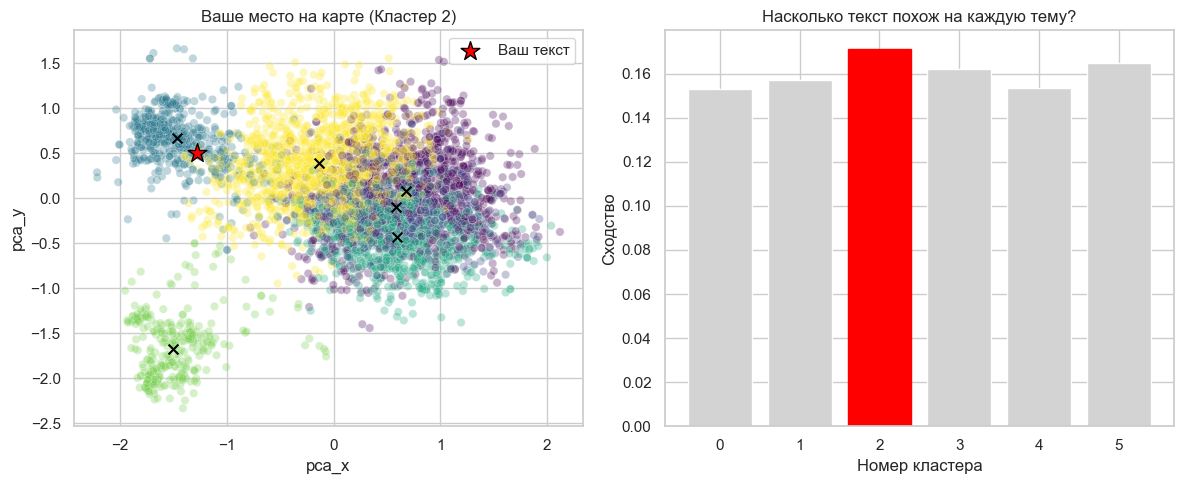

In [10]:
#Примеры для проверки
test_phrases = [
    "Я обожаю программировать нейросети на Python",
    "В свободное время играю на гитаре и пишу песни",
    "Люблю готовить пироги для всей семьи",
    "Не знаю чем заняться, просто лежу",
    "История древнего Рима и археологические раскопки"
]

for phrase in test_phrases:
    analyze_text(phrase, show_plots=True)

📊 Топ-7 слов для каждого кластера:

🔹 КЛАСТЕР 0 (Анкет: 1176)
игра (152), технология (131), цифровой (122), рок (114), электронный (108), мир (98), психология (95)
--------------------------------------------------


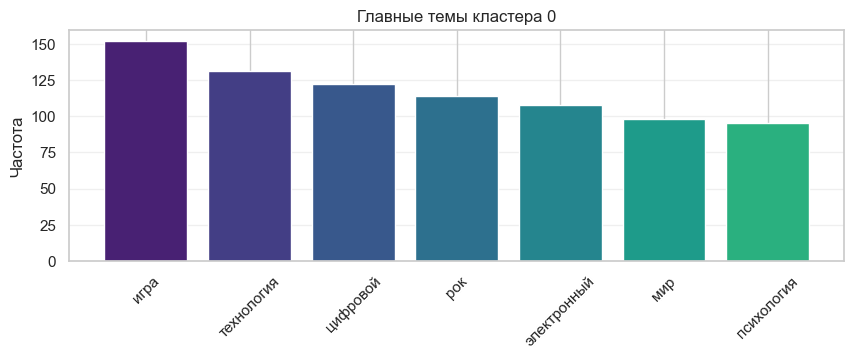

🔹 КЛАСТЕР 1 (Анкет: 626)
природа (296), растение (214), сад (134), ботанический (90), ботаник (83), деревенский (72), животное (70)
--------------------------------------------------


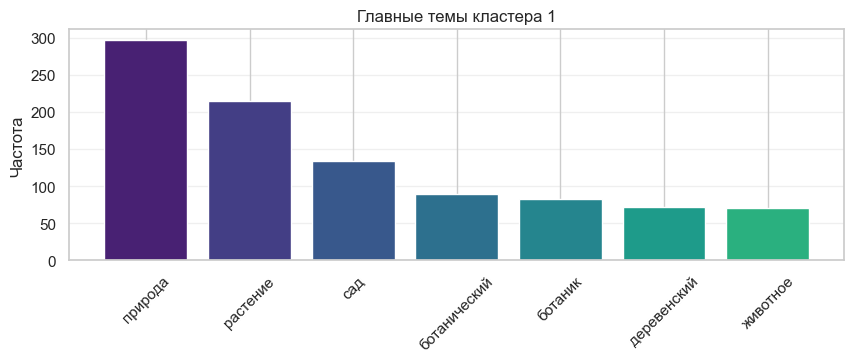

🔹 КЛАСТЕР 2 (Анкет: 675)
культура (701), историк (480), народный (441), греческий (431), традиция (343), славянский (311), проведение (243)
--------------------------------------------------


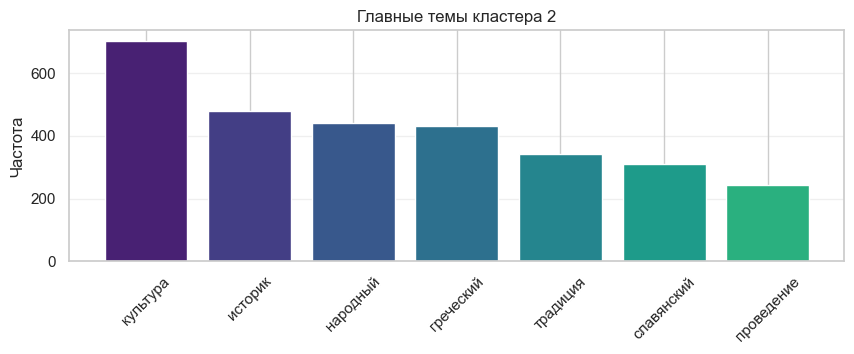

🔹 КЛАСТЕР 3 (Анкет: 913)
морской (250), военный (227), карта (134), рок (123), подводный (118), астрономия (110), море (109)
--------------------------------------------------


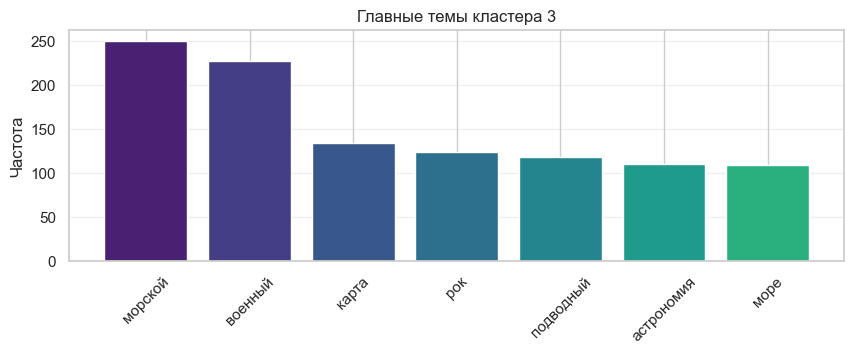

🔹 КЛАСТЕР 4 (Анкет: 360)
церковный (332), семья (293), духовный (287), веровать (267), песнопение (266), православный (245), монастырь (235)
--------------------------------------------------


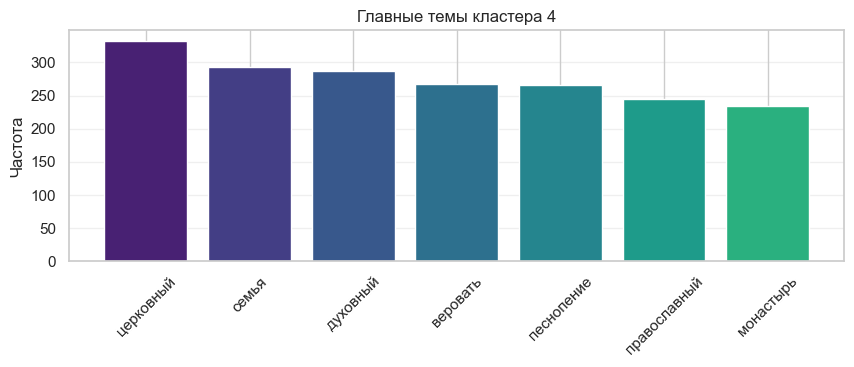

🔹 КЛАСТЕР 5 (Анкет: 1306)
инструмент (171), музыкальный (167), техника (131), танец (123), эпоха (119), художник (115), игра (114)
--------------------------------------------------


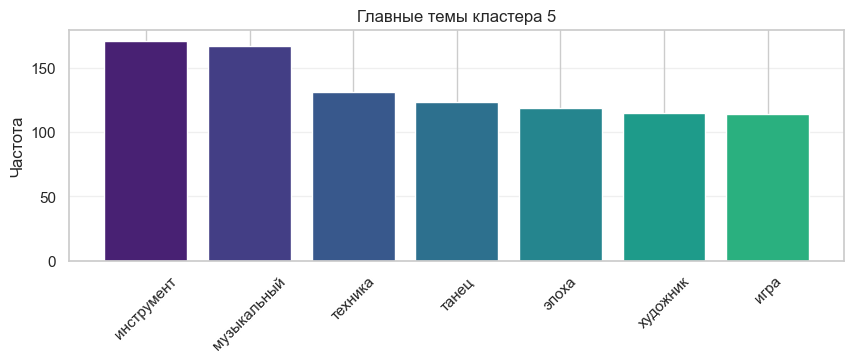

In [11]:
from collections import Counter

print("📊 Топ-7 слов для каждого кластера:\n")

for i in range(n_clusters):
    #Берем все тексты, попавшие в этот кластер
    cluster_df = df[df['cluster'] == i]
    texts = cluster_df['processed_text']
    
    #Собираем все слова в одну кучу
    all_words = []
    for text in texts:
        all_words.extend(text.split())
        
    #Считаем частоту
    counter = Counter(all_words)
    top_words = counter.most_common(7)
    
    #Вывод текстом
    print(f"🔹 КЛАСТЕР {i} (Анкет: {len(texts)})")
    print(", ".join([f"{word} ({count})" for word, count in top_words]))
    print("-" * 50)

    #Визуализация (График-столбики)
    if top_words:
        words, counts = zip(*top_words)
        
        plt.figure(figsize=(10, 3))
        bars = plt.bar(words, counts, color=sns.color_palette("viridis", 10))
        
        plt.title(f'Главные темы кластера {i}', fontsize=12)
        plt.ylabel('Частота')
        plt.xticks(rotation=45)
        plt.grid(axis='y', alpha=0.3)
        plt.show()

Основываясь на ключевых словах, можно дать следующим кластерам такие названия:

🔹 КЛАСТЕР 0: Технологии и Гик-культура (Ключевые слова: игра, технология, цифровой, электронный, психология) Это «современный» кластер: геймеры, айтишники, любители гаджетов, современной музыки (рок, электроника) и саморазвития.

🔹 КЛАСТЕР 1: Природа и Садоводство (Ключевые слова: природа, растение, сад, ботанический, животное) Сюда попали любители флоры и фауны, дачники, ботаники и те, кто предпочитает проводить время на свежем воздухе.

🔹 КЛАСТЕР 2: История и Этнография (Ключевые слова: культура, историк, народный, греческий, славянский, традиция) Здесь находятся любители истории, народных традиций, фольклора и изучения культурного наследия (как своего, так и античного).

🔹 КЛАСТЕР 3: Романтика приключений (Море, Космос, Милитари) (Ключевые слова: морской, военный, карта, подводный, астрономия) Группа с «мужскими» или исследовательскими хобби: военная история, флот, дайвинг, астрономия и путешествия.

🔹 КЛАСТЕР 4: Духовность и Традиции (Ключевые слова: церковный, духовный, веровать, православный, монастырь) Здесь собраны люди, для которых важны вера, религия, семейные ценности и духовное развитие.

🔹 КЛАСТЕР 5: Искусство и Творчество (Ключевые слова: инструмент, музыкальный, танец, художник, игра) Этот кластер объединяет творческих личностей: музыкантов, художников, танцоров и тех, кто увлекается классическими видами искусства.


In [12]:
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import numpy as np

input_text = "Сажаю растения, люблю цветы, обожаю ухаживать за маленькими полисадниками. Ищу того, кто любил бы природу и цветочки" 
print(f"Пользователь вводит: \"{input_text}\"\n")

processed_query = preprocess_text(input_text)
tokens = processed_query.split()
print(f"1. Текст очищен до токенов: {', '.join(tokens)}")

query_embedding = model.encode([processed_query])

predicted_cluster = kmeans.predict(query_embedding)[0]

cluster_data = df[df['cluster'] == predicted_cluster]

all_cluster_words = []
for text in cluster_data['processed_text']:

    words = str(text).split()
    all_cluster_words.extend([w for w in words if len(w) > 3])

top_words_pairs = Counter(all_cluster_words).most_common(5)
top_words_str = ", ".join([word for word, count in top_words_pairs])

print(f"2. Система классифицирует вектор в Кластер {predicted_cluster} (Ключевые слова: {top_words_str})")

similarities = cosine_similarity(query_embedding, embeddings)[0]

df_search = df.copy()
df_search['similarity'] = similarities

top_5 = df_search.sort_values(by='similarity', ascending=False).head(5)

print("\n3. В выдаче появляются кандидаты (Топ-5):")
for i, (idx, row) in enumerate(top_5.iterrows(), 1):
    desc_preview = row['Описание'][:80].strip() + "..."
    print(f"   {i}. {desc_preview} (Сходство: {row['similarity']:.0%})")

avg_score = top_5['similarity'].mean()
print(f"\nРезультат: Средняя совместимость топ-5 кандидатов составила {avg_score:.0%}.")


Пользователь вводит: "Сажаю растения, люблю цветы, обожаю ухаживать за маленькими полисадниками. Ищу того, кто любил бы природу и цветочки"

1. Текст очищен до токенов: сажать, растение, цветок, ухаживать, маленький, полисадник, природа, цветочек
2. Система классифицирует вектор в Кластер 1 (Ключевые слова: природа, растение, ботанический, ботаник, деревенский)

3. В выдаче появляются кандидаты (Топ-5):
   1. Хай! Меня зовут Розалия, 25 лет, работаю в ботаническом саду ботаником-флорист... (Сходство: 83%)
   2. Приветик! Я Лилиана, 27 лет, работаю в ботаническом саду ботаником-флористом. С... (Сходство: 82%)
   3. Привет! Я Лилия, 25 лет, работаю в ботаническом саду ботаником-флористом. Смот... (Сходство: 82%)
   4. Здравствуйте! Меня зовут Лилия, 26 лет, работаю в ботаническом саду ботаником-ф... (Сходство: 82%)
   5. Здравствуйте! Меня зовут Лилия, 25 лет, работаю в ботаническом саду ботаником-... (Сходство: 82%)

Результат: Средняя совместимость топ-5 кандидатов составила 82%.


In [13]:
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import numpy as np

input_text = "Пою в церковном хоре. Проповедуюсь, хожу в воскресную школу. Хочу создать крепкую православную семью" 
print(f"Пользователь вводит: \"{input_text}\"\n")

processed_query = preprocess_text(input_text)
tokens = processed_query.split()
print(f"1. Текст очищен до токенов: {', '.join(tokens)}")

query_embedding = model.encode([processed_query])

predicted_cluster = kmeans.predict(query_embedding)[0]

cluster_data = df[df['cluster'] == predicted_cluster]

all_cluster_words = []
for text in cluster_data['processed_text']:

    words = str(text).split()
    all_cluster_words.extend([w for w in words if len(w) > 3])

top_words_pairs = Counter(all_cluster_words).most_common(5)
top_words_str = ", ".join([word for word, count in top_words_pairs])

print(f"2. Система классифицирует вектор в Кластер {predicted_cluster} (Ключевые слова: {top_words_str})")

similarities = cosine_similarity(query_embedding, embeddings)[0]

df_search = df.copy()
df_search['similarity'] = similarities

top_5 = df_search.sort_values(by='similarity', ascending=False).head(5)

print("\n3. В выдаче появляются кандидаты (Топ-5):")
for i, (idx, row) in enumerate(top_5.iterrows(), 1):
    desc_preview = row['Описание'][:80].strip() + "..."
    print(f"   {i}. {desc_preview} (Сходство: {row['similarity']:.0%})")

avg_score = top_5['similarity'].mean()
print(f"\nРезультат: Средняя совместимость топ-5 кандидатов составила {avg_score:.0%}.")

Пользователь вводит: "Пою в церковном хоре. Проповедуюсь, хожу в воскресную школу. Хочу создать крепкую православную семью"

1. Текст очищен до токенов: поить, церковный, хор, проповедоваться, ходить, воскресный, школа, создать, крепкий, православный, семья
2. Система классифицирует вектор в Кластер 4 (Ключевые слова: церковный, семья, духовный, веровать, песнопение)

3. В выдаче появляются кандидаты (Топ-5):
   1. Хай! Меня зовут Вера, 24 года, работаю в церкви преподавателем воскресной школы.... (Сходство: 85%)
   2. Приветик! Я Матрона, 28 лет, работаю в церкви помощницей настоятеля и алтарниц... (Сходство: 82%)
   3. Хай! Меня зовут Христина, 25 лет, работаю в церкви регентом хора. Фанатка "Сестр... (Сходство: 82%)
   4. Здорово! Я Ефросинья, 25 лет, работаю в церкви певчей в хоре. Смотрю "Сестра Мар... (Сходство: 81%)
   5. Здравствуйте! Меня зовут Христина, 26 лет, работаю в церкви регентом хора. Смотр... (Сходство: 81%)

Результат: Средняя совместимость топ-5 кандидатов составил

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import numpy as np

input_text = "Работаю Python разработчиком, интересуюсь Data Science, по вечерам играю в видеоигры и читаю фантастику"
print(f"Пользователь вводит: \"{input_text}\"\n")

processed_query = preprocess_text(input_text)
tokens = processed_query.split()
print(f"1. Текст очищен до токенов: {', '.join(tokens)}")

query_embedding = model.encode([processed_query])

predicted_cluster = kmeans.predict(query_embedding)[0]

cluster_data = df[df['cluster'] == predicted_cluster]

all_cluster_words = []
for text in cluster_data['processed_text']:

    words = str(text).split()
    all_cluster_words.extend([w for w in words if len(w) > 3])

top_words_pairs = Counter(all_cluster_words).most_common(5)
top_words_str = ", ".join([word for word, count in top_words_pairs])

print(f"2. Система классифицирует вектор в Кластер {predicted_cluster} (Ключевые слова: {top_words_str})")

similarities = cosine_similarity(query_embedding, embeddings)[0]

df_search = df.copy()
df_search['similarity'] = similarities

top_5 = df_search.sort_values(by='similarity', ascending=False).head(5)

print("\n3. В выдаче появляются кандидаты (Топ-5):")
for i, (idx, row) in enumerate(top_5.iterrows(), 1):
    desc_preview = row['Описание'][:80].strip() + "..."
    print(f"   {i}. {desc_preview} (Сходство: {row['similarity']:.0%})")

avg_score = top_5['similarity'].mean()
print(f"\nРезультат: Средняя совместимость топ-5 кандидатов составила {avg_score:.0%}.")


Пользователь вводит: "Работаю Python разработчиком, интересуюсь Data Science, по вечерам играю в видеоигры и читаю фантастику"

1. Текст очищен до токенов: разработчик, интересоваться, вечер, играть, видеоигра, читать, фантастика
2. Система классифицирует вектор в Кластер 0 (Ключевые слова: игра, технология, цифровой, электронный, психология)

3. В выдаче появляются кандидаты (Топ-5):
   1. Хай! Меня зовут Матвей, 25 лет, я программист-разработчик игр в инди-студии. Обо... (Сходство: 70%)
   2. Ростислав, 43  Геймдизайнер. Создаю нарративы и механики для видеоигр. Увлекаюс... (Сходство: 67%)
   3. Ирина, 32 года. Гейм-дизайнер. Разрабатываю нарративы и механики для мобильных и... (Сходство: 67%)
   4. Здравствуйте! Меня зовут Аркадий, 27 лет, работаю в IT-компании разработчиком и... (Сходство: 67%)
   5. Приветик! Я Аркадий, 28 лет, работаю в игровой индустрии геймдизайнером. Смотрю... (Сходство: 67%)

Результат: Средняя совместимость топ-5 кандидатов составила 68%.
